# TP Coding a variational autoencoder in tensorflow/keras

Author : Alasdair Newson

alasdair.newson@telecom-paris.fr

## Objective:

The goal of this second part of the TP is to implement a variational autoencoder applied to MNIST.

### Your task:
You need to add the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE or # FILL IN CODE)

First of all, let's load some packages

In [1]:


import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Add, Multiply, Reshape, Flatten, Dropout, BatchNormalization, Activation, ZeroPadding2D, MaxPooling2D, Lambda,LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras import backend as K

First, we define a function to load the database

In [2]:
def load_data():
  (X_train, Y_train_scalar), (X_test, Y_test_scalar) = mnist.load_data()

  n_max = 10000
  X_train = X_train[0:n_max,:,:]
  X_test = X_test[0:n_max,:,:]
  Y_train_scalar = Y_train_scalar[0:n_max]
  Y_test_scalar = Y_test_scalar[0:n_max]

  # normalise images between 0 and 1
  X_train = X_train/255.0
  X_test = X_test/255.0
  #add a channel dimension, if need be (for mnist data)
  if(X_train.ndim ==3):
    X_train = np.expand_dims(X_train, axis=3)
    X_test = np.expand_dims(X_test, axis=3)
  return X_train,X_test

We define the parameters of the variational autoencoder

In [3]:

X_train,X_test = load_data()

# image parameters
n_iters = 4000
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
img_channels = X_train.shape[3]
img_size = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]
img_shape = (img_rows, img_cols, img_channels)
z_dim = 10

batch_size=64
sample_interval=100

optimizer = Adam(0.01) #


11493376/11490434 [==============================] - 0s 0us/step


Here, we need to define a special function for the sampling of the random latent code. This code is given :

In [4]:
def sampling(args):
  z_mean, z_log_var = args
  #Reparameterization trick
  batch_size = K.shape(z_mean)[0]
  z_dim = K.shape(z_mean)[1]
  # sample random vector of size (batch_size,z_dim)
  epsilon = K.random_normal(shape=(batch_size,z_dim))
  z_sigma = K.exp(0.5 * z_log_var)
  z_epsilon = Multiply()([z_sigma,epsilon])
  z_rand = Add()([z_mean,z_epsilon])
  return z_rand

Now, we need to define the variational autoencoder loss. In the case of an image which is represented by a set of __Bernoulli__ variables (the case for mnist), the loss function is written :


\begin{equation}
\mathcal{L} = \sum_{i} x_i \log y_i + (1-x_i) \log (1-y_i) - \frac{1}{2} \sum_j \left( \sigma_j^2 + \mu_j^2 - \log \sigma_j^2 -1 \right)
\end{equation}

where $i$ is summed over the image pixels, and $j$ is summed over the elements of the latent space. $\sigma_j^2$ is the $j$th element of the latent space variance, and $\mu_j$ is the $j$th element of the latent space mean.

The left part of the loss (reconstruction error) can be implemented simply as the binary cross-entropy between the input x and the output y.

For the right part (KL divergence), you need to implement it manually. You should use the following backend functions :

- K.sum
- K.binary_crossentropy
- K.square
- K.exp
- K.mean

Important note : the binary_crossentropy loss function in Keras calculates the mean of the individual cross-entropies of the pixels. If you decide to use this function, either multiply it by the number of pixels to scale it, or you can use the backend binary cross-entropy (```K.binary_crossentropy```) and then take the sum over the last axis (the second option is more rigourous).

The final loss is the average, over the batch size, of the sum of the reconstruction error (left part) and the KL divergence (right part).

In [5]:

def vae_loss(x,y,z_mean,z_log_var):
  # BEGIN FILL IN CODE

  reconstruction_loss = K.sum(K.binary_crossentropy(x, y), axis=-1)

  # KL divergence
  kl_div = (0.5)*K.sum(K.exp(z_log_var)+K.square(z_mean)-z_log_var-1,axis=-1)
  vae_loss = K.mean(reconstruction_loss+kl_div)

  # END FILL IN CODE
  return vae_loss

We now define the architecture of the model. This code is given.

In [6]:
n_pixels = img_rows*img_cols*img_channels

#build encoder
input_img = Input(shape=(img_rows,img_cols,img_channels))
input_img_flatten = Flatten()(input_img)
z = Dense(512,name='z_intermediate')(input_img_flatten)
z = LeakyReLU(alpha=0.2)(z)
# mean and variance parameters
z_mean = Dense(z_dim, name='z_mean')(z)
z_log_var = Dense(z_dim, name='z_log_var')(z)

#sample the latent vector
z_rand = Lambda(sampling, output_shape=(z_dim,))([z_mean, z_log_var])

#save the encoder
encoder = Model(input_img, [z_mean, z_log_var, z_rand], name='encoder')

#build decoder
latent_inputs = Input(shape=(z_dim,), name='z_sampling')
y = Dense(512)(latent_inputs)
y = LeakyReLU(alpha=0.2)(y)
output_img = Dense(n_pixels, activation='sigmoid')(y)
decoder = Model(latent_inputs, output_img, name='decoder')

#build encoder + decoder (total model)
output_img = decoder(encoder(input_img)[2])
vae = Model(input_img, output_img, name='vae_mlp')

#create the total model
vae_model = Model(input_img,output_img)
#define the loss
vae_loss = vae_loss(input_img_flatten, output_img,z_mean,z_log_var)
vae_model.add_loss(vae_loss)
vae_model.compile(optimizer=optimizer)
vae_model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 10), (None,  412180      input_1[0][0]                    
__________________________________________________________________________________________________
decoder (Functional)            (None, 784)          407824      encoder[0][2]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           input_1[0][0]                    
______________________________________________________________________________________________

We define a function to sample the VAE results

In [7]:

def sample_images(vae_decoder,z_dim,img_shape):

  (img_rows,img_cols,img_channels) = img_shape
  n_images = 8
  #get output images
  z_sample = np.random.normal(0,1,(n_images,z_dim))
  r = 1
  c = n_images
  fig, axs = plt.subplots(r, c)
  for j in range(c):
    x_decoded = np.reshape(vae_decoder.predict(z_sample) , (n_images,img_rows,img_cols,img_channels))
    #black and white images
    axs[j].imshow(x_decoded[j, :,:,0], cmap='gray')
    axs[j].axis('off')
  plt.show()


Now, train the model. Use the same technique as you used at the end of the first part of the TP.

0 [Loss: 546.521729]


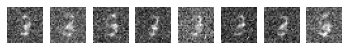

100 [Loss: 139.725891]


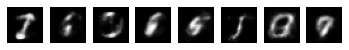

200 [Loss: 135.552170]


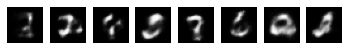

300 [Loss: 127.686394]


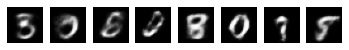

400 [Loss: 122.704620]


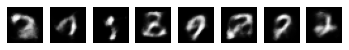

500 [Loss: 122.273598]


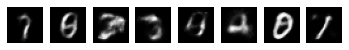

600 [Loss: 124.197662]


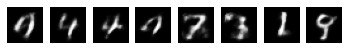

700 [Loss: 120.566879]


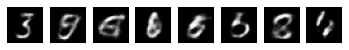

800 [Loss: 114.812645]


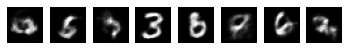

900 [Loss: 118.412201]


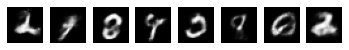

1000 [Loss: 122.939499]


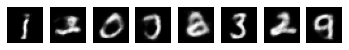

1100 [Loss: 113.195915]


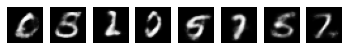

1200 [Loss: 117.923454]


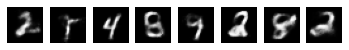

1300 [Loss: 115.512123]


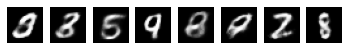

1400 [Loss: 117.701477]


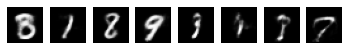

1500 [Loss: 114.959503]


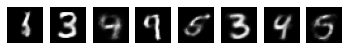

1600 [Loss: 118.538216]


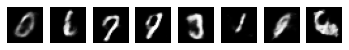

1700 [Loss: 115.850067]


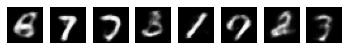

1800 [Loss: 113.031647]


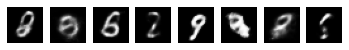

1900 [Loss: 113.774521]


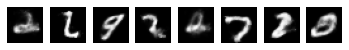

2000 [Loss: 112.692657]


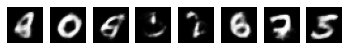

2100 [Loss: 114.661926]


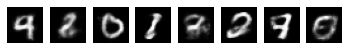

2200 [Loss: 112.301880]


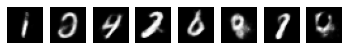

2300 [Loss: 112.414345]


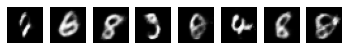

2400 [Loss: 113.572533]


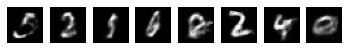

2500 [Loss: 116.164459]


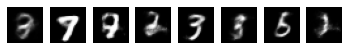

2600 [Loss: 107.250885]


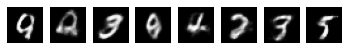

2700 [Loss: 111.813599]


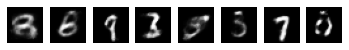

2800 [Loss: 111.644478]


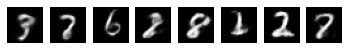

2900 [Loss: 113.472687]


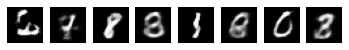

3000 [Loss: 112.689964]


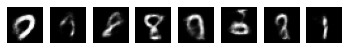

3100 [Loss: 115.778938]


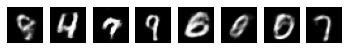

3200 [Loss: 112.918076]


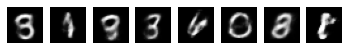

3300 [Loss: 114.071625]


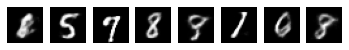

3400 [Loss: 113.719528]


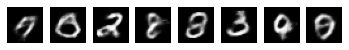

3500 [Loss: 113.060219]


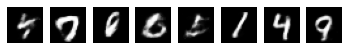

3600 [Loss: 112.676643]


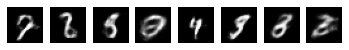

3700 [Loss: 109.522842]


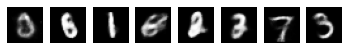

3800 [Loss: 110.839401]


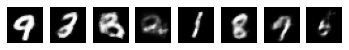

3900 [Loss: 114.868774]


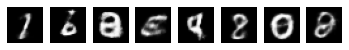

In [8]:

batch_size=128
sample_interval=100

for i in range(0,n_iters):

  # BEGIN FILL IN CODE
  # Select a random batch of images
  curr_batch = X_train[np.random.randint(0, X_train.shape[0], batch_size),:,:,:]
  
  # Autoencoder training (train on batch)
  loss = vae_model.train_on_batch(curr_batch,curr_batch)

  # END FILL IN CODE


  # Save some random generated images and the models at every sample_interval iterations
  if (i % sample_interval == 0):
    # print the losses
    print("%d [Loss: %f]" % (i, loss))
    sample_images(decoder, z_dim,img_shape)


What do you think of the results ? You can try and change the latent space dimension size to see if this improves the quality of the results.

The results obtained are still not verry clear. As the CNN in the previous notebook, we can see that they are digits, but some of them are not clear. If we increase the dimensional space, the numbers should became more clear (“sharp”), as when we are I a low dimensional in the latent space, the autoencoder takes a sort of mean of the digits, making them blurry.